In [12]:
#Numpy
import numpy as np
#Scipy
from scipy import special as scsp
from scipy import stats
from numpy import random as rdm
#Pyplot
import matplotlib.pyplot as plt
#Multi-CPU job
from joblib import Parallel, delayed
import multiprocessing as mpg
#Time
import time
#Json
import json

# Stochastic processes

##### Model parameters from Meyer & Bijeljic 2016

In [2]:
#Bentheimer 500 parameters
Bentheimer500 ={
'name'  : 'Bentheimer 500',
'L0'    :  1.5,      #Sample length [mm]
'Deltax':  3.0,      #Resolution [um]
'n'     :  500,      #Nb of 1D points
'L0/L'  :  11.2,     #Pore length ratio [-]
'phi'   :  0.21,     #Porosity [%]
'kappa' :  1.26,     #Tortuosity [-]
'lmbd/L':  8.33,     #Correlation length [-]
#Theta angle model
'omegat':  5.0,
'taut'  :  0.093,
'sigmat':  0.59,
'mut'   :  41.0,
#Beta angle model
'taub'  :  0.11,
'bb'    :  2.0,
#Log velocity magnitude model
'b'     :  0.56,
'c'     :  1.1,
'alpha' : -4.7,
'mu'    :  1.5,
'sigma' :  2.7
}
#Bentheimer 1000 parameters
Bentheimer1000 ={
'name'  :  'Bentheimer 1000',
'L0'    :  3.0,      #Sample length [mm]
'Deltax':  3.0,      #Resolution [um]
'n'     :  1000,     #Nb of 1D points
'L0/L'  :  22.6,     #Pore length ratio [-]
'phi'   :  0.22,     #Porosity [%]
'kappa' :  1.65,     #Tortuosity
'lmbd/L':  8.32,     #Correlation length [-]
#Theta angle model
'omegat':  4.3,
'taut'  :  0.12,
'sigmat':  0.69,
'mut'   :  38.0,
#Beta angle model
'taub'  :  0.13,
'bb'    :  1.9,
#Log velocity magnitude model
'b'     :  0.57,
'c'     :  1.3,
'alpha' : -3.6,
'mu'    :  1.5,
'sigma' :  2.5
}
#Estaillades parameters
Estaillades = {
'name'  :  'Estaillades',
'L0'    :  3.31,     #Sample length [mm]
'Deltax':  3.31,     #Resolution [um]
'n'     :  1000,     #Nb of 1D points
'L0/L'  :  11.7,     #Pore length ratio [-]
'phi'   :  0.11,     #Porosity [%]
'kappa' :  2.26,     #Tortuosity
'lmbd/L':  36.2,     #Correlation length [-]
#Theta angle model
'omegat':  10.0,
'taut'  :  0.018,
'sigmat':  0.84,
'mut'   :  17.0,
#Beta angle model
'taub'  :  0.014,
'bb'    :  7.0,
#Log velocity magnitude model
'b'     :  0.63,
'c'     :  3.0,
'alpha' : -5.1,
'mu'    :  2.2,
'sigma' :  5.1
}

## 1) Log velocity model from Meyer and Bijeljic 2016

#### 1.1) PDF, drift and diffusion functions

In [3]:
#Skew-normal PDF
def p_skew(v,sample) :
    alpha = sample['alpha']
    mu    = sample['mu']
    sigma = sample['sigma']
    p = 1/np.sqrt(2.0*np.pi*sigma**2)*np.exp(-(v-mu)**2/(2.0*sigma**2))*scsp.erfc(-alpha*(v-mu)/np.sqrt(2.0*sigma**2))
    return p


#Diffusion function from DWM
def d(v,sample) :
    b = sample['b']
    c = sample['c']
    return c*np.exp(b*v)

#Drift function from DWM
def a(v,sample) :
    eps  = 0.1
    p_p1 = p_skew(v+eps,sample); p_m1 = p_skew(v-eps,sample);
    d_p1 = d(v+eps,sample);      d_m1 = d(v-eps,sample);
    d_   = d(v,sample);
    grad = (np.log(p_p1 * d_p1)-np.log(p_m1 * d_m1))/(2.0*eps)
    return d_/2.0 * grad

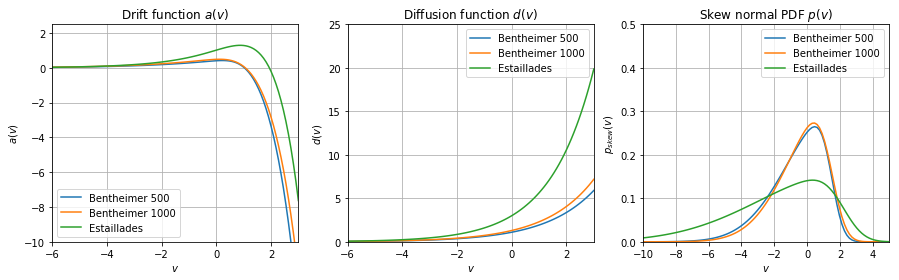

In [4]:
samples = [Bentheimer500, Bentheimer1000, Estaillades]
nv=100
(v_min, v_max) = (-6.0, 3.0)
v=np.linspace(v_min,v_max,nv)
dv= (v_max-v_min)/nv
fig, axs = plt.subplots(1,3, figsize= (15,4))

for (i,sample) in zip(range(len(samples)),samples) :
    axs[0].plot(v,a(v,sample),label = sample['name'])
    axs[1].plot(v,d(v,sample),label = sample['name'])
    axs[2].plot(np.linspace(-10,5,nv),p_skew(np.linspace(-10,5,nv),sample),label = sample['name'])

axs[0].set_title(r'Drift function $a(v)$')
axs[0].set_xlabel(r'$v$')
axs[0].set_ylabel(r'$a(v)$')
axs[0].set_xlim((-6,3))
axs[0].set_ylim((-10,2.5))
axs[0].legend()
axs[0].grid(True)

axs[1].set_title(r'Diffusion function $d(v)$')
axs[1].set_xlabel('$v$')
axs[1].set_ylabel(r'$d(v)$')
axs[1].set_xlim((-6,3))
axs[1].set_ylim((0,25))
axs[1].legend()
axs[1].grid(True)

axs[2].set_title(r'Skew normal PDF $p(v)$')
axs[2].set_xlabel('$v$')
axs[2].set_ylabel(r'$p_{skew}(v)$')
axs[2].set_xlim((-10,5))
axs[2].set_ylim((0,0.5))
axs[2].legend()
axs[2].grid(True)

#### Log velocity markov process

In [41]:
#Log velocity magnitude model from Meyer and Bijeljic 2016
def LVM_process(sample, param):
    if param['seed'] is not None : 
        rdm.seed(param['seed'])
    else :
        rdm.seed()
    Tmax = param['Tmax']; dt  = param['dt']; 
    v0   = param['v0'];   csf = param['csf']; 
    Nt        = int(Tmax/dt)+1
    delta     = dt #Wiener process 
    track     = range(int(Nt/csf)) #If we do not want to track the whole evolution
    v_track   = np.zeros(int(Nt/csf)) #Resulting time serie
    v_        = v0
    for i in range(Nt) :
        if (i in track):
            v_track[i] = v_
        dv = a(v_,sample)*dt + np.sqrt(d(v_,sample))*rdm.normal(loc=0.0, scale=np.sqrt(dt), size=None)
        v_ = v_ + dv
    return v_track

## Running processes

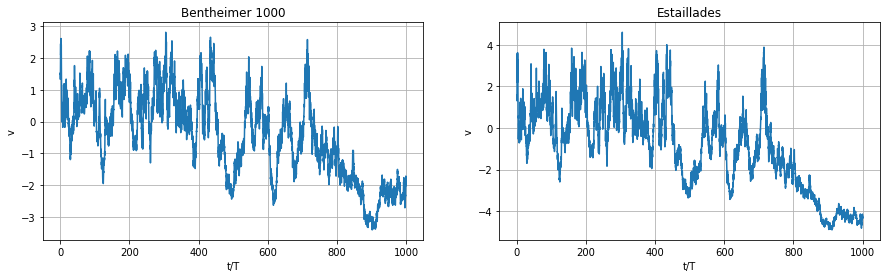

In [48]:
samples = [Bentheimer1000, Estaillades]
Nmp = 1
MP_params = {
'seed': 12345,
'v0'  : 1.5,
'dt'  : 0.01,
'Tmax': 1000.0,
'csf' : 10.0
}
MP_example  = {'params' : MP_params}

for sample in samples :
    MP_example[sample['name']]  = Parallel(n_jobs=8)(
        delayed(LVM_process)
        (sample, MP_params) for i in range(Nmp))
fig, axs = plt.subplots(1,2, sharey = False, figsize=(15,4))
for (i,sample) in zip(range(len(samples)),samples) :
    for n in range(Nmp) :
        Tmax = MP_example['params']['Tmax']
        Nt   = len(MP_example[sample['name']][n])
        timerange = np.linspace(0,Tmax,Nt)
        axs[i].plot(timerange,MP_example[sample['name']][n],'-')
        axs[i].grid(True);
        axs[i].set_ylabel('v');
        axs[i].set_xlabel('t/T');
        axs[i].set_title(sample['name']);

### Process Statistics and PDF comparison

In [20]:
samples = [Bentheimer1000, Estaillades]
Nmp = 100
MP_params = {
'v0'  : 1.5,
'dt'  : 0.005,
'Tmax': 10.0,
'csf' : 1.0
}
MP_lvm  = {'params' : MP_params}

for sample in samples :
    MP_lvm[sample['name']]  = Parallel(n_jobs=6)(
        delayed(LVM_process)
        (sample, MP_params) for i in range(Nmp))
    MP_lvm[sample['name']]=np.reshape(MP_lvm[sample['name']],int(Nt/csf)*Nmp)

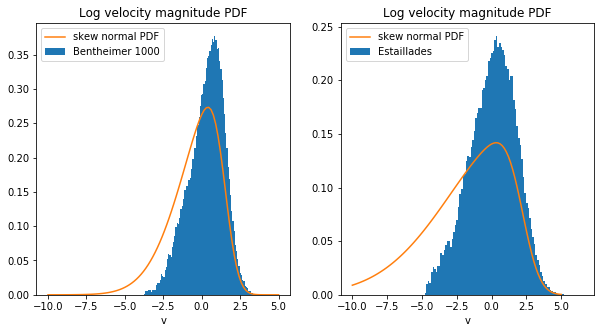

In [21]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
NBINS = 100
#for i in range(1,int(Nt/csf)) :
#    vpdf=plt.hist(MP_lvm[:,i], bins = 10, density = True, alpha = 0.3)
for (i,sample) in zip(range(len(samples)),samples) :
    axs[i].hist(MP_lvm[sample['name']], bins = NBINS, density = True, log = False, label = sample['name'])
    v = np.linspace(-10,5,100)
    axs[i].plot(v,p_skew(v,sample), label = 'skew normal PDF');
    axs[i].set_title('Log velocity magnitude PDF')
    axs[i].set_xlabel('v')
    axs[i].legend()

In [24]:
#Copy MP_lvm into non np array dict
MP_lvm_nonp = {}
for key in MP_lvm : MP_lvm_nonp[key] = [v for v in MP_lvm[key]]
with open('../data/Markov_processes/MP_lvm.dat', 'w') as outfile:  
    json.dump(MP_lvm_nonp, outfile)
del MP_lvm_nonp

# Loading and processing DNS data

##### Computing Ux mean from Eulerian velocities

In [ ]:
Ndat  = 300
phi   = Bentheimer300['phi']
ux    = np.loadtxt('../data/Bentheimer300/Ux.dat')
print('Ux dimensions : '+str(np.shape(ux)))
Umean = np.mean(ux[:][0]) #Mean flow velocity as the mean over the first yz section of the domain
print('Ue_x mean = '+str(Umean))

In [ ]:
uux = ux.reshape(Ndat**3)

In [ ]:
Umean = 0
for (i2,i3) in zip(range(Ndat),range(Ndat)) :
    i1 = 0
    #Umean += uux[Ndat*Ndat*i3 + Ndat*i2 + i1]
    Umean += uux[Ndat*Ndat*i3 + Ndat*i2 + i1]
Umean = Umean/(Ndat**2)/phi
print('U = ' + str(Umean))

#### Some data files 

In [ ]:
DATA = {
    'D=1.0E-9, CSF=5' : '../data/Bentheimer300/sl_out_M0_DM1.0E-9_SLSM200_TMAX0.0E2_CSF5.dat',
    'D=0.0, CSF=1'    : '../data/Bentheimer300/sl_out_M0_DM0.0E-9_SLSM200_TMAX0.0E2_CSF1.dat',
    'DWM_test'        : '../data/Bentheimer300/DWM_test.txt',
    'Ubuntu_test'     : '../data/Bentheimer300/Ubuntu_test.dat'
}
KEYS = ['D=1.0E-9, CSF=5','D=0.0, CSF=1','DWM_test','Ubuntu_test']

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

COLOR = {
    'D=1.0E-9, CSF=5' : color_cycle[0],
    'D=0.0, CSF=1'    : color_cycle[1],
    'DWM_test'        : color_cycle[2],
    'Ubuntu_test'     : color_cycle[3] 
}

In [ ]:
vDNS = {} #Log velocity magnitude
tDNS = {} #Time
for key in DATA :
    with open(DATA[key], 'r') as f:
        lines   = (line for line in f if len(line)>11)
        dataDNS = np.genfromtxt(lines)
    tDNS[key] = dataDNS[:,0]
    uxDNS     = dataDNS[:,4]
    uyDNS     = dataDNS[:,5]
    uzDNS     = dataDNS[:,6]
    print(key + '\t: NtDNS = '+str(len(tDNS[key])))
    del dataDNS
    #DNS log velocity magnitude
    vDNS[key] = np.array([np.log(np.sqrt(ux**2+uy**2+uz**2)/Umean) for (ux,uy,uz) in zip(uxDNS, uyDNS, uzDNS) if np.sqrt(ux**2+uy**2+uz**2) > 0])
    del uxDNS, uyDNS, uzDNS #Free some memory

#### DNS log velocity magnitude

In [ ]:
for key in DATA :
    plt.hist(vDNS[key], bins = 1000, density = True, alpha = 0.4, label = key, color = COLOR[key]);
plt.legend();
plt.xlabel('v');

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].set_title('Evolution of time with steps');
for key in DATA : axs[0].plot(tDNS[key][range(100)],'.--', label = key, color = COLOR[key]);
axs[0].set_xlabel('step');
axs[0].set_ylabel('t');
axs[0].legend();

axs[1].set_title('Same with only diffusive and DWM test');
for key in ['D=1.0E-9, CSF=5', 'DWM_test'] : axs[1].plot(tDNS[key][range(100)],'.--', label = key, color = COLOR[key]);
axs[1].set_xlabel('step');
axs[1].set_ylabel('t');
axs[1].legend();

## Making DNS data isochronous

##### Compiling streamlines into one single stream lines (ssl)

In [ ]:
def ssl_transform(N,t,v) :
    dt      = [t1-t0 for (t1,t0) in zip(t[range(1,N)],t[range(N-1)])]
    dt_ssl  = [dt_ for dt_ in dt if dt_ > 0] #filtering
    N_ssl   = len(dt_ssl)
    t_ssl   = np.zeros(N_ssl)
    #t_ssl  = [t_ssl[i-1] + dt_ssl[i] for i in range(1,N_ssl)]
    T = 0.0
    for i in range(N_ssl) :
        t_ssl[i] = T
        T += dt_ssl[i]
    v_ssl   = np.array([v for (v,dt) in zip(v,dt) if dt > 0])
    return t_ssl, dt_ssl, v_ssl

In [ ]:
vDNS_ssl = {}
tDNS_ssl = {}
dtDNS_ssl = {}
dtDNS_mean  = {}
Npoints = 10000
fig, ax = plt.subplots(1,1)

for key in DATA :
    #Npoints = len(tDNS[key]) #For the full data set
    tDNS_ssl[key], dtDNS_ssl[key], vDNS_ssl[key] = ssl_transform (Npoints, tDNS[key], vDNS[key])
    dtDNS_mean[key] = np.mean(dtDNS_ssl[key])
    print (key + '\t mean time step : '+str(dtDNS_mean[key]))
    hist = plt.hist(np.log(dtDNS_ssl[key]),bins=100,density=True, alpha=0.0);
    ax.plot(hist[1][0:-1],hist[0], label = key, color = COLOR[key])
ax.set_title('Distribution of time step');
ax.set_xlabel('log(dt)')
ax.legend();

#### Isochronous transform of DNS data

In [ ]:
#pointwise linear interpolation
def lin_interp(v1,t1,v0,t0,t) :
    v = v0 + (v1-v0) * (t-t0)/(t1-t0)
    return v

#isochronous transform for one point i
def isochronous_transform_process(t_serie, v_serie, dt, i) :
    t_i  = i*dt
    m  = 0
    t1 = -1
    while(t1 <= t_i) :
        m += 1;
        t1 = t_serie[m]
    v1 = v_serie[m]
    t0 = t_serie[m-1]
    v0 = v_serie[m-1]
    v_i  = lin_interp(v1,t1,v0,t0,t_i)
    return v_i

#parallel isochronous transform
def parallel_isochronous_transform(ncores, t_serie, v_serie, dt) :
    T_end    = t_serie[-1]
    Nt_iso   = int(T_end/dt)-1
    v_iso    = Parallel(n_jobs=ncores)(
        delayed(isochronous_transform_process)
        (t_serie, v_serie, dt, i) for i in range(Nt_iso))
    return v_iso

In [ ]:
#Dictionnary to store isochronous transforms with various dt
v_iso  = {} #log velocity magn
t_iso  = {} #time (linspace(0,T,dt))
Nt_iso = {} #number of points
dt_iso = {} #time step of isochronous serie
#Isochronous transform
ncores = 6
for key in DATA :
    dt = int(1000*dtDNS_mean[key])/5000.0
    start = time.time()
    v_iso [key]  = parallel_isochronous_transform(ncores, tDNS_ssl[key], vDNS_ssl[key], dt)
    Nt_iso[key]  = len(v_iso[key])
    t_iso [key]  = np.linspace(0,dt*Nt_iso[key],Nt_iso[key])
    dt_iso[key]  = dt
    end = time.time()
    print('for '+key+' dt = '+str(dt))
    print('\tdt = '+str(dt))
    print('\tNumber of points \t: '+str(Nt_iso[key]))
    print('\tTime needed \t: '+str(end-start))

In [ ]:
#Verification of the isochronous transform by comparing it to original data
key    = KEYS[2]
N      = 10
Tmax   = tDNS_ssl[key][N]
N_iso  = int(Tmax/dt_iso[key])

fig, ax = plt.subplots(1,1)
ax.set_title('Check isochronous interpolation');
ax.plot(tDNS_ssl[key][0:N],vDNS_ssl[key][0:N],'.--',color = COLOR[key], label = key); #Isochronous series
ax.plot(t_iso[key][0:N_iso],v_iso[key][0:N_iso],'x'); #rough DNS series
ax.set_xlabel('t');
ax.set_ylabel('v');
ax.legend();

#### Comparisons to summarize

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(20,11));
hist_DNS = {} #to store DNS histogram as a line
hist_iso = {} #to store isochronous histogram as a line
(i,j) = (0,0)
axs[i,j].set_title('Log velocity magnitude histogram for DNS series');
axs[i,j].set_xlabel('v')
#
for key in DATA :
    hist_DNS[key] = axs[i,j].hist(vDNS_ssl[key], bins = 100, label = key, color = COLOR[key], density = True, alpha= 0.5);
axs[i,j].legend();

(i,j) = (1,0)
axs[i,j].set_title('Log velocity magnitude histogram for isochronous series');
axs[i,j].set_xlabel('v')
#hist_DNS = axs[i,j].hist(vDNS_ssl[key], bins = 100, label = 'DNS data', density = True, alpha= 0.5);
for key in DATA :
    hist_iso[key] = axs[i,j].hist(v_iso[key], bins = 100, label = key, color = COLOR[key],  density = True, alpha= 0.5);
axs[i,j].legend();

(i,j) = (0,1)
axs[i,j].set_title('PDF for DNS data');
axs[i,j].set_xlabel('v')
axs[i,j].set_ylabel(r'$p(v)$')
for key in DATA :
    axs[i,j].plot(hist_DNS[key][1][0:-1]    ,hist_DNS[key][0], label = key, color = COLOR[key])
axs[i,j].plot(hist_iso[key][1], p_skew(hist_iso[key][1],Bentheimer300),'--k', label = 'SNP for Benth300');
axs[i,j].legend();

(i,j) = (1,1)
axs[i,j].set_title('PDF for Isochronous series');
axs[i,j].set_xlabel('v')
axs[i,j].set_ylabel(r'$p(v)$')
for key in DATA :
    axs[i,j].plot(hist_iso[key][1][0:-1]    ,hist_iso[key][0], label = 'dt = '+key)
axs[i,j].plot(hist_iso[key][1], p_skew(hist_iso[key][1],Bentheimer300), '--k', label = 'SNP for Benth300');
axs[i,j].legend();
del hist_DNS, hist_iso

## Comparing DNS data with Markov model and PDF

In [ ]:
model ={
'name'  : 'Model',
'alpha' : -3.6,
'mu'    :  8.2,
'sigma' :  1.4
}
fig, axs = plt.subplots(2,2,figsize=(20,11), sharex=True, sharey=True)
sample   = Bentheimer300
vrange = np.linspace(-10,10,100)
count    = 0
for key in DATA :
    data1 = vDNS_ssl[key]
    data2 = v_iso[key]
    data3 = MP_lvm[sample['name']]
    (i,j) = (int(count/2),np.mod(count,2))
    axs[i,j].set_title('Overall comparison for ' + key)
    axs[i,j].hist(data1, bins = 100, label = key+' DNS',         density = True, alpha= 0.5)
    axs[i,j].hist(data2, bins = 100, label = key+' Isochronous', density = True, alpha= 0.5)
    axs[i,j].hist(data3, bins = 100, label = 'Markov process',   density = True, alpha= 0.5)
    axs[i,j].plot(vrange, p_skew(vrange,sample), label = 'SNP for Benth300');
    axs[i,j].plot(vrange, p_skew(vrange,model),  label = 'DWM test fitted SNP');
    axs[i,j].grid(True)
    axs[i,j].set_xlabel('v')
    axs[i,j].set_ylabel('p(v)')
    axs[i,j].legend()
    count += 1
del data1, data2, data3